<a href="https://colab.research.google.com/github/dvircohen0/Machine-Learning-Algorithms-From-Scratch/blob/main/LENET5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import warnings


**Load TensoFlow MNIST dataset**

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',split=['train', 'test'],
    shuffle_files=True, as_supervised=True,
    with_info=True)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


Pad image from 28x28 to 32x32

In [ ]:
def normalize_img(image, label):
  image =tf.pad(image, [[2,2],[2,2],[0,0]],mode='CONSTANT')
  return tf.cast(image, tf.float32) / 255., label


ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

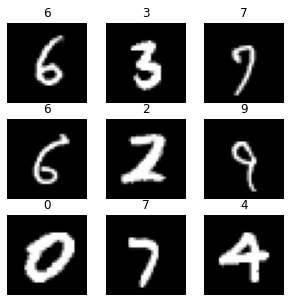

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
for images, labels in ds_train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    X=images[i].numpy().reshape([32, 32]);
    plt.imshow(X,cmap='gray')
    plt.title(labels[i].numpy())
    plt.axis("off")

Build LENET5 model

![picture](https://cdn-images-1.medium.com/max/1024/1*DMcPgeekUftwk0GTMcNawg.png)


In [ ]:
LeNet5_model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(input_shape=(32,32,1),filters=6,kernel_size=(5, 5),activation='relu'),
  tf.keras.layers.AveragePooling2D(),
  tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5), activation='relu'),
  tf.keras.layers.AveragePooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(120,activation='relu'),
  tf.keras.layers.Dense(84,activation='relu'),
  tf.keras.layers.Dense(10,activation = 'softmax')
])

LeNet5_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 6)         156       
_________________________________________________________________
average_pooling2d_6 (Average (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
average_pooling2d_7 (Average (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 120)               48120     
_________________________________________________________________
dense_10 (Dense)             (None, 84)               

In [ ]:
LeNet5_model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
          metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],)

history =LeNet5_model.fit(ds_train,epochs=6,validation_data=ds_test)

Epoch 1/6
469/469 [==============================] - 4s 7ms/step - loss: 0.7999 - sparse_categorical_accuracy: 0.7776 - val_loss: 0.1385 - val_sparse_categorical_accuracy: 0.9569
Epoch 2/6
469/469 [==============================] - 3s 6ms/step - loss: 0.1300 - sparse_categorical_accuracy: 0.9608 - val_loss: 0.0796 - val_sparse_categorical_accuracy: 0.9756
Epoch 3/6
469/469 [==============================] - 3s 6ms/step - loss: 0.0817 - sparse_categorical_accuracy: 0.9743 - val_loss: 0.0803 - val_sparse_categorical_accuracy: 0.9735
Epoch 4/6
469/469 [==============================] - 3s 6ms/step - loss: 0.0629 - sparse_categorical_accuracy: 0.9803 - val_loss: 0.0546 - val_sparse_categorical_accuracy: 0.9828
Epoch 5/6
469/469 [==============================] - 3s 6ms/step - loss: 0.0514 - sparse_categorical_accuracy: 0.9839 - val_loss: 0.0475 - val_sparse_categorical_accuracy: 0.9845
Epoch 6/6
469/469 [==============================] - 3s 6ms/step - loss: 0.0437 - sparse_categorical_accu

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


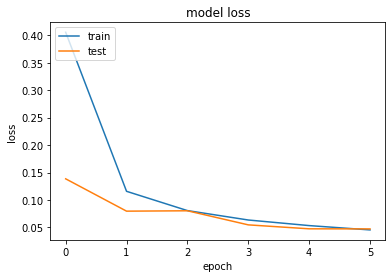

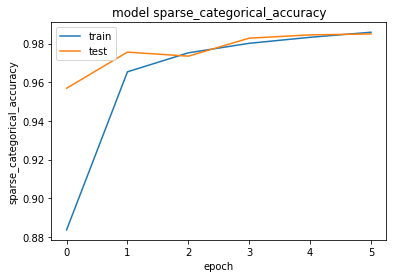

In [ ]:

print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model sparse_categorical_accuracy')
plt.ylabel('sparse_categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Predict MNIST pictures with VGG16**

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input,decode_predictions

In [ ]:
test_vgg = tfds.load(
    'mnist',split='train[:10]',
    shuffle_files=True, as_supervised=True)

def vgg_normalize_img(image, label):
  image=tf.image.grayscale_to_rgb(image)
  image = tf.image.resize(image,[224,224])
  return preprocess_input(image), label


test_vgg = test_vgg.map(
    vgg_normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_vgg = test_vgg.batch(10)
test_vgg = test_vgg.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
model_vgg =VGG16()

preds=model_vgg.predict(test_vgg)
class_pred=decode_predictions(preds,top=1)

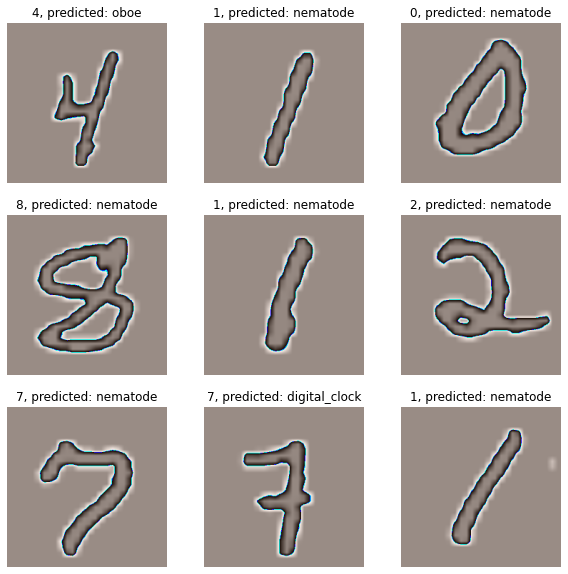

In [ ]:
for images, labels in test_vgg.take(-1):
    images = images.numpy()
    labels = labels.numpy()
plt.figure(figsize=(10, 10))

for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(images[i].astype('uint8'))
  plt.title(str(labels[i])+", predicted: " + class_pred[i][0][1])
  plt.axis("off")